## WorldPop_Insights.ipynb  
This notebook investigates how population has evolved over time across countries, regions, and development groups. By tracing long-term trends, identifying inflection points, and applying smoothing techniques, it reveals the momentum and volatility behind global demographic shifts.  
A foundation for historical insight, predictive modeling, and policy foresight.

Population is not static‚Äîit‚Äôs a story unfolding across decades. From post-war booms to modern slowdowns, each curve tells us something about migration, fertility, urbanization, and resilience. Some nations surge forward, others plateau, and a few reverse course entirely.

In this notebook, we analyze population trajectories from 1960 to 2024 using World Bank data. We visualize growth arcs, apply moving averages to detect stability, and spotlight historical leaders and laggards. Forecasting models like linear extrapolation and Holt-Winters offer glimpses into what lies ahead.

This is more than time-series analysis. It‚Äôs a chronicle of demographic transformation‚Äîwhere history meets data, and trends become tools for understanding the future.

### Selected Visual References:
- [Population Forecasting](https://www.planning.org/pas/reports/report17.htm) ‚Äî Overview of forecasting methods and planning implications  
- [Population projections and forecasting techniques | Fiveable](https://library.fiveable.me/population-and-society/unit-2/population-projections-forecasting-techniques/study-guide/pJd1ttAMGyS3YGWU) ‚Äî Educational breakdown of projection models  
- [The World of Population Projections - Population Matters](https://populationmatters.org/news/2024/04/the-world-of-population-projections/) ‚Äî Global outlook on demographic futures  
- [Some examples of trend extrapolation population projection methods](https://www.researchgate.net/figure/Some-examples-of-trend-extrapolation-population-projection-methods_tbl2_279535374) ‚Äî Tabular comparison of forecasting techniques  
- [Understanding Population Projections: Assumptions Behind the Numbers | PRB](https://www.prb.org/resources/understanding-population-projections-assumptions-behind-the-numbers/) ‚Äî Analytical deep dive into projection logic  
- [Population Projection - an overview | ScienceDirect Topics](https://www.sciencedirect.com/topics/social-sciences/population-projection) ‚Äî Academic summary of modeling approaches  


##Data Import and Setup

We start by importing libraries and loading the raw datasets:
- `raw_pop_data`: World Bank population totals by country and year  
- `country_metadata`: Metadata including region, income group, and classification

These data sources underpin all time-series and comparative analysis throughout this notebook.


In [3]:
# Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load raw data
raw_pop_data = pd.read_csv("API_SP.POP.TOTL_DS.csv", skiprows=4)
country_metadata = pd.read_csv("Meta_country.csv")

# Preview head of data
raw_pop_data.head()


Country Name Country Code     Indicator Name Indicator Code  \
0                        Aruba          ABW  Population, total    SP.POP.TOTL   
1  Africa Eastern and Southern          AFE  Population, total    SP.POP.TOTL   
2                  Afghanistan          AFG  Population, total    SP.POP.TOTL   
3   Africa Western and Central          AFW  Population, total    SP.POP.TOTL   
4                       Angola          AGO  Population, total    SP.POP.TOTL   

          1960         1961         1962         1963         1964  \
0      54922.0      55578.0      56320.0      57002.0      57619.0   
1  130075728.0  133534923.0  137171659.0  140945536.0  144904094.0   
2    9035043.0    9214083.0    9404406.0    9604487.0    9814318.0   
3   97630925.0   99706674.0  101854756.0  104089175.0  106388440.0   
4    5231654.0    5301583.0    5354310.0    5408320.0    5464187.0   

          1965  ...         2016         2017         2018         2019  \
0      58190.0  ...     108727.0     108735.0     108908.0     109203.0   
1  149033472.0  ...  623369401.0  640058741.0  657801085.0  675950189.0   
2   10036008.0  ...   34700612.0   35688935.0   36743039.0   37856121.0   
3  108772632.0  ...  429454743.0  440882906.0  452195915.0  463365429.0   
4    5521981.0  ...   29183070.0   30234839.0   31297155.0   32375632.0   

          2020         2021         2022         2023         2024  \
0     108587.0     107700.0     107310.0     107359.0     107624.0   
1  694446100.0  713090928.0  731821393.0  750503764.0  769294618.0   
2   39068979.0   40000412.0   40578842.0   41454761.0   42647492.0   
3  474569351.0  485920997.0  497387180.0  509398589.0  521764076.0   
4   33451132.0   34532429.0   35635029.0   36749906.0   37885849.0   

   Unnamed: 69  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 70 columns]

*Successfully loaded population figures and country-level metadata. Ready to transform and explore temporal trends.*


### Data Transformation: Long Format for Time-Series

To perform time-series analysis, we reshape the population dataset from wide to long format. Each row will now represent a country-year combination. We then merge with metadata to enrich each record with region and income group information.


In [13]:
# Reshape population data to long format
years = [str(y) for y in range(1960, 2025)]
pop_long = raw_pop_data.melt(id_vars=['Country Name', 'Country Code'], value_vars=years, var_name='Year', value_name='Population')
pop_long['Year'] = pop_long['Year'].astype(int)

# Merge with metadata and drop missing regions/income groups
pop_meta_long = pd.merge(pop_long, country_metadata, on='Country Code', how='left').dropna(subset=['Region', 'IncomeGroup'])



*Time-series data structured and metadata attached. Ready for visual and statistical analysis.*


### Time-Series Plot: Selected Countries

We visualize historical population growth for selected countries to observe their trajectories across six decades. These curves help identify sharp growth phases and relative changes over time.


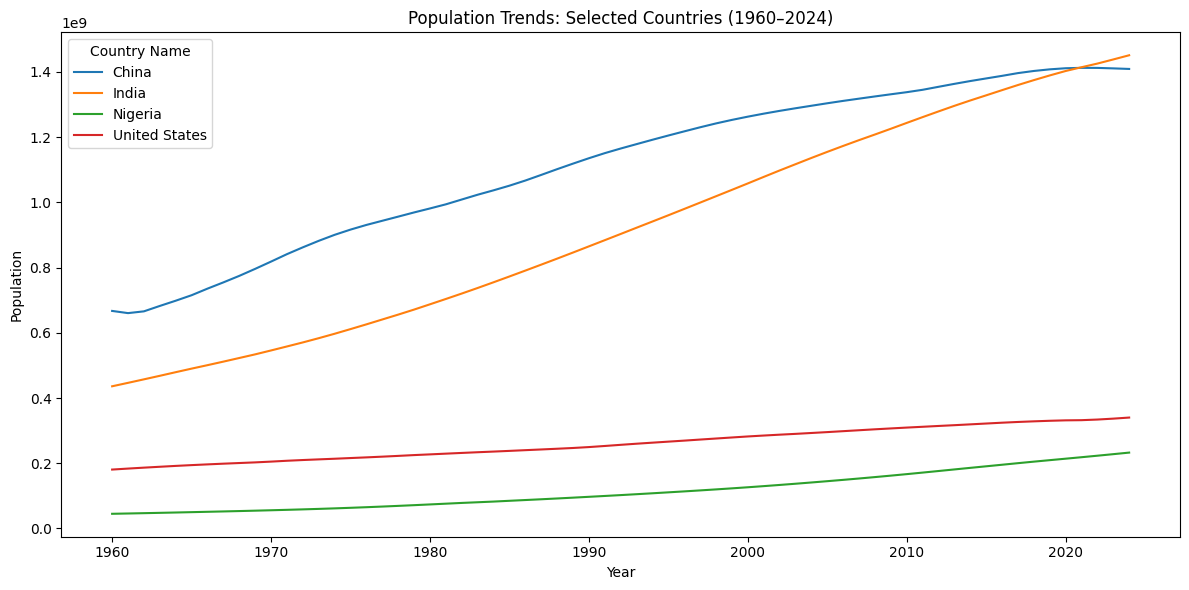

In [ ]:
# Filter for selected countries
filtered = pop_meta_long[pop_meta_long['Country Name'].isin(['India', 'China', 'Nigeria', 'United States'])]

# Plot population trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered, x='Year', y='Population', hue='Country Name')
plt.title('Population Trends: Selected Countries (1960‚Äì2024)')
plt.ylabel('Population')
plt.tight_layout(); plt.show()


*Country-level patterns reveal dramatic differences in population scaling and tempo.*


### Moving Averages: Smoothing Growth

To better understand growth momentum and stability, we smooth the raw population series with a 5-year moving average. This reduces noise and emphasizes overall trends.


C:\Users\A\AppData\Local\Temp\ipykernel_6004\1133255705.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['Smoothed'] = filtered.groupby('Country Name')['Population'].transform(


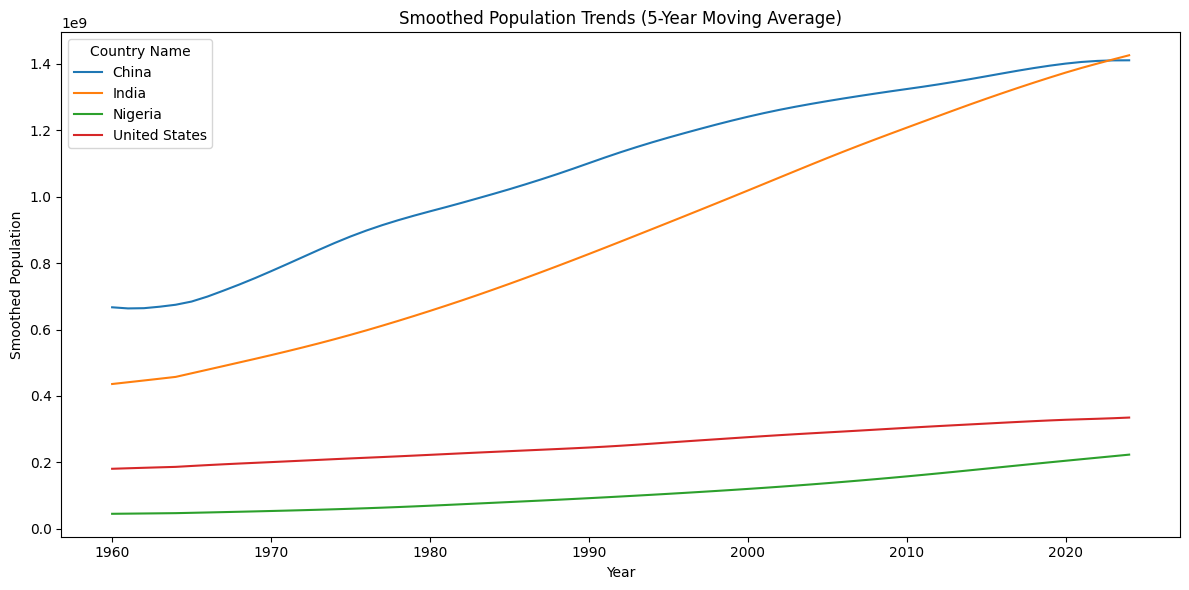

In [ ]:
# Apply 5-year moving average
filtered['Smoothed'] = filtered.groupby('Country Name')['Population'].transform(lambda x: x.rolling(5, min_periods=1).mean())

# Plot smoothed trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered, x='Year', y='Smoothed', hue='Country Name')
plt.title('Smoothed Population Trends (5-Year Moving Average)')
plt.ylabel('Smoothed Population')
plt.tight_layout(); plt.show()


*Smoothed plots show consistent growth paths and help isolate underlying demographic shifts.*


### Regional Growth Over Time

Here we aggregate country-level data to examine regional population totals over time. This view highlights how continents and subregions evolve demographically.


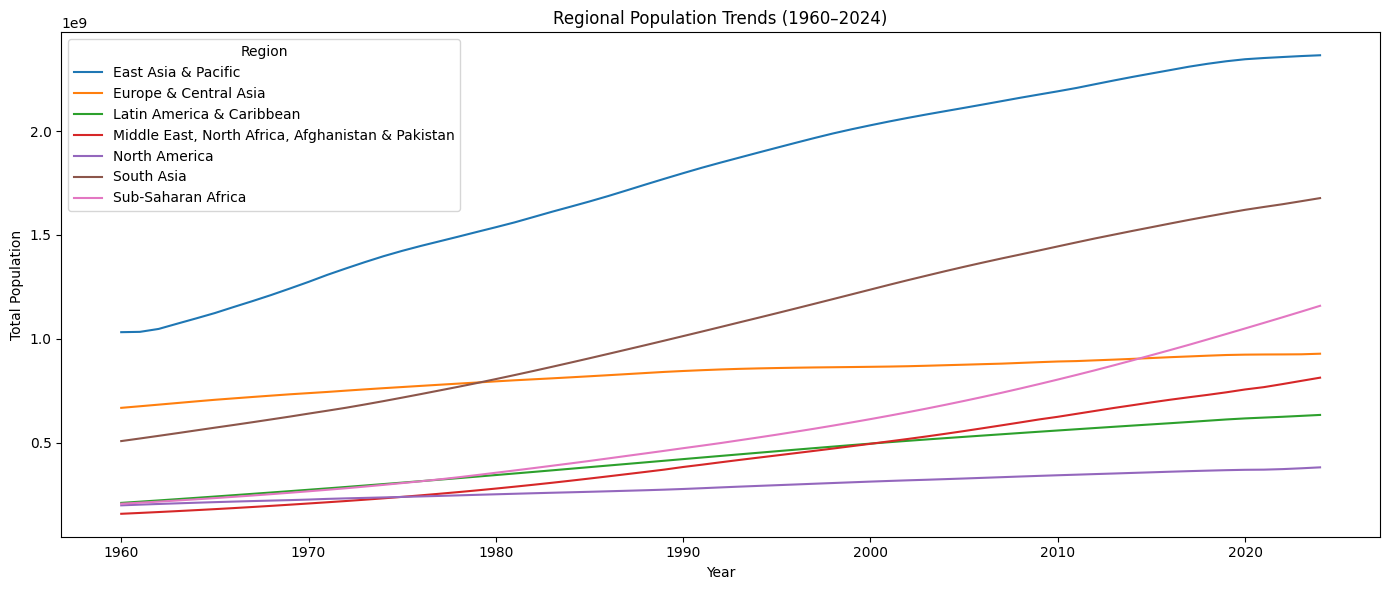

In [ ]:
# Aggregate population by region and year
region_year = pop_meta_long.groupby(['Region', 'Year'])['Population'].sum().reset_index()

# Plot regional trends
plt.figure(figsize=(14, 6))
sns.lineplot(data=region_year, x='Year', y='Population', hue='Region')
plt.title('Regional Population Trends (1960‚Äì2024)')
plt.ylabel('Total Population')
plt.tight_layout(); plt.show()



*Regional curves help pinpoint large-scale growth shifts and geographic concentration.*


### üîç Historical Growth Leaders & Laggards

We calculate total population growth from 1960 to 2024 for each country to identify the top and bottom performers globally. This ranking exposes uneven development and demographic volatility.


C:\Users\A\AppData\Local\Temp\ipykernel_6004\713078461.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_growth.index, y=top_growth['Growth'], ax=axes[0], palette='crest')
C:\Users\A\AppData\Local\Temp\ipykernel_6004\713078461.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bottom_growth.index, y=bottom_growth['Growth'], ax=axes[1], palette='flare')


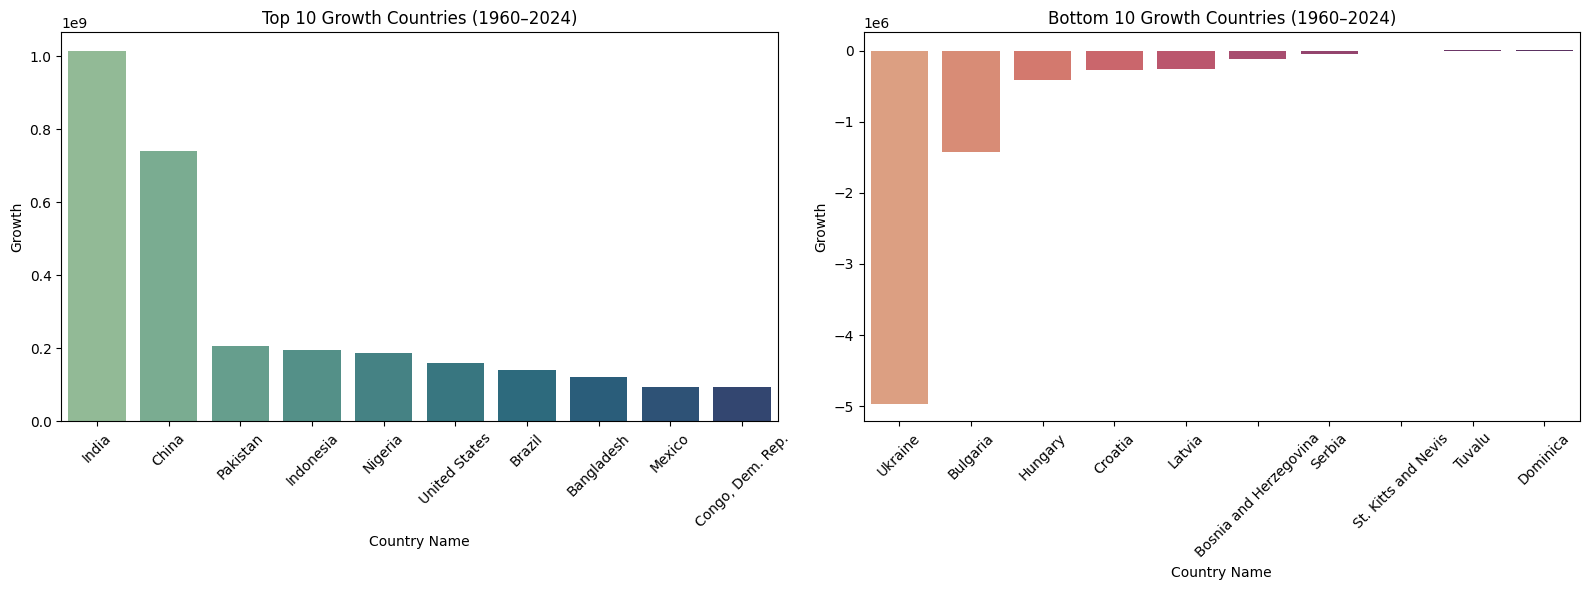

In [ ]:
# Calculate population growth between 1960 and 2024
growth_df = pop_meta_long[pop_meta_long['Year'].isin([1960, 2024])]
pivot_growth = growth_df.pivot(index='Country Name', columns='Year', values='Population')
pivot_growth['Growth'] = pivot_growth[2024] - pivot_growth[1960]

# Top and bottom 10 countries by growth
top_growth = pivot_growth.sort_values('Growth', ascending=False).head(10)
bottom_growth = pivot_growth.sort_values('Growth').head(10)

# Plot growth bars
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(x=top_growth.index, y=top_growth['Growth'], ax=axes[0], palette='crest')
axes[0].set_title('Top 10 Growth Countries (1960‚Äì2024)')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x=bottom_growth.index, y=bottom_growth['Growth'], ax=axes[1], palette='flare')
axes[1].set_title('Bottom 10 Growth Countries (1960‚Äì2024)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout(); plt.show()



*These growth extremes showcase the demographic divide‚Äîbetween explosive growth and stagnation.*


### Light Forecasting: Linear Regression

Using linear regression, we project population estimates for India between 2025‚Äì2035. This model assumes continuation of historical growth patterns and offers a baseline forecast.


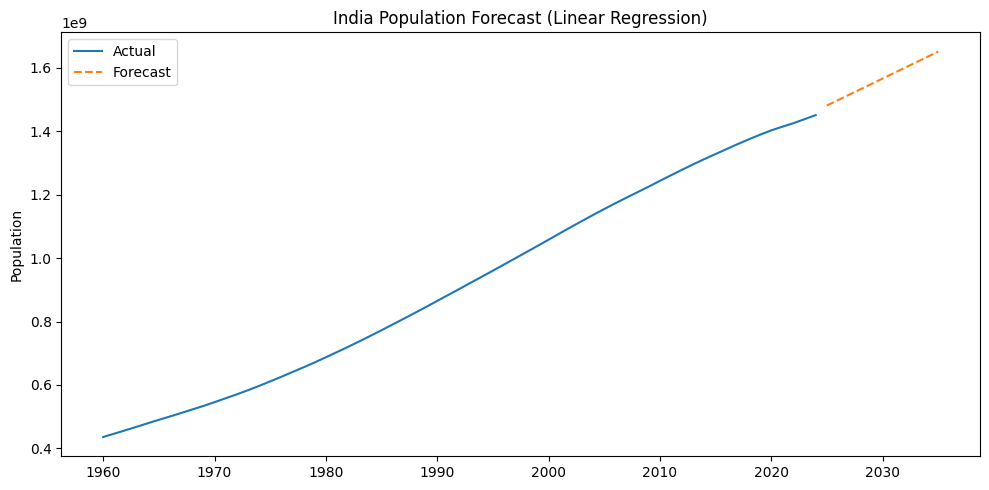

In [ ]:
# Linear regression on India's population
from sklearn.linear_model import LinearRegression

india_data = filtered[filtered['Country Name'] == 'India']
X, y = india_data[['Year']], india_data['Population']

model = LinearRegression().fit(X, y)
future_years = pd.DataFrame({'Year': range(2025, 2036)})
future_preds = model.predict(future_years)

# Plot actual vs forecast
plt.figure(figsize=(10, 5))
plt.plot(india_data['Year'], india_data['Population'], label='Actual')
plt.plot(future_years['Year'], future_preds, '--', label='Forecast')
plt.title('India Population Forecast (Linear Regression)')
plt.ylabel('Population')
plt.legend(); plt.tight_layout(); plt.show()

plt.tight_layout()
plt.show()


*Forecast lines extend India‚Äôs growth trajectory and invite analysis of future planning needs.*


### üîó Correlation: Region vs Income Group Over Time

We overlay regional and income group trends to examine structural differences in growth patterns. This fusion reveals how development classification intersects with demographic expansion.


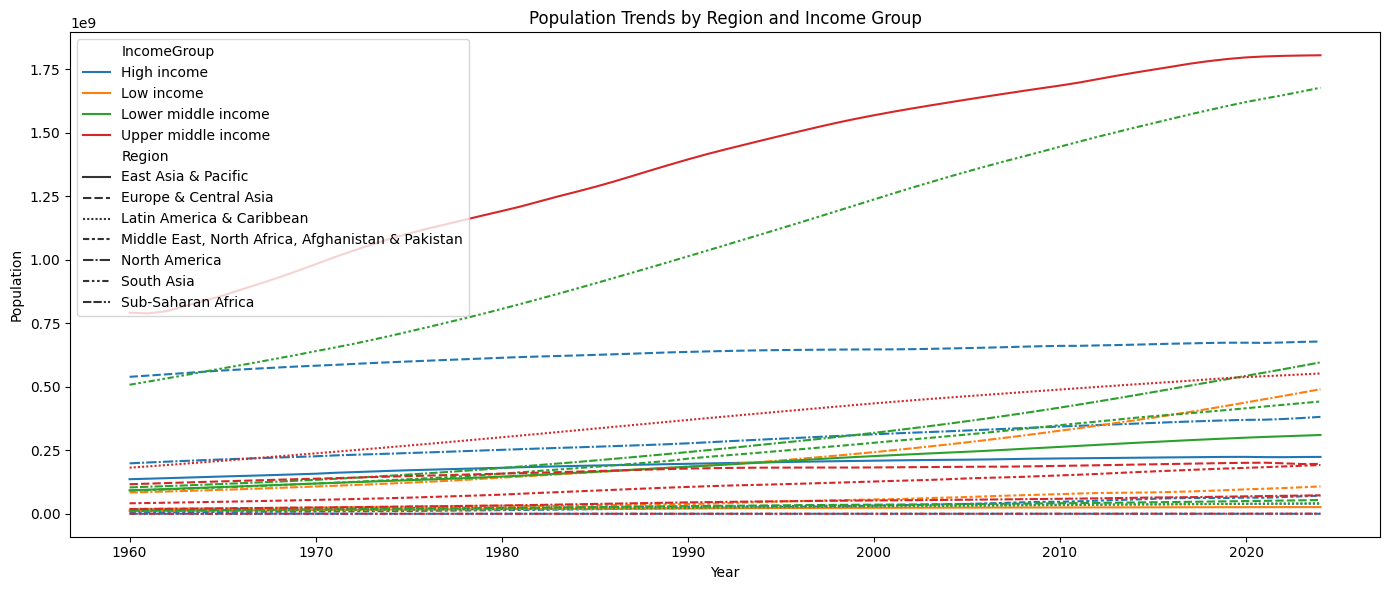

In [ ]:
# Group by region, income group, and year
corr_df = pop_meta_long.groupby(['Region', 'IncomeGroup', 'Year'])['Population'].sum().reset_index()

# Plot trends by region and income group
plt.figure(figsize=(14, 6))
sns.lineplot(data=corr_df, x='Year', y='Population', hue='IncomeGroup', style='Region')
plt.title('Population Trends by Region and Income Group')
plt.ylabel('Population')
plt.tight_layout(); plt.show()



In [ ]:
# Clean and merge datasets
pop_df = pop_df.drop(columns=['Unnamed: 69'])
meta_df = meta_df.drop(columns=['Unnamed: 5'])

# Merge population data with metadata
merged_df = pd.merge(pop_df, meta_df, on='Country Code', how='left')

# Focus on recent population figures (e.g., 2024)
merged_df['2024'] = merged_df['2024'].fillna(0)
merged_df_clean = merged_df.dropna(subset=['Region', 'IncomeGroup'])

merged_df_clean.head()


Country Name Country Code     Indicator Name Indicator Code       1960  \
0        Aruba          ABW  Population, total    SP.POP.TOTL    54922.0   
2  Afghanistan          AFG  Population, total    SP.POP.TOTL  9035043.0   
4       Angola          AGO  Population, total    SP.POP.TOTL  5231654.0   
5      Albania          ALB  Population, total    SP.POP.TOTL  1608800.0   
6      Andorra          AND  Population, total    SP.POP.TOTL     9510.0   

        1961       1962       1963       1964        1965  ...        2019  \
0    55578.0    56320.0    57002.0    57619.0     58190.0  ...    109203.0   
2  9214083.0  9404406.0  9604487.0  9814318.0  10036008.0  ...  37856121.0   
4  5301583.0  5354310.0  5408320.0  5464187.0   5521981.0  ...  32375632.0   
5  1659800.0  1711319.0  1762621.0  1814135.0   1864791.0  ...   2854191.0   
6    10283.0    11086.0    11915.0    12764.0     13634.0  ...     76474.0   

         2020        2021        2022        2023        2024  \
0    108587.0    107700.0    107310.0    107359.0    107624.0   
2  39068979.0  40000412.0  40578842.0  41454761.0  42647492.0   
4  33451132.0  34532429.0  35635029.0  36749906.0  37885849.0   
5   2837849.0   2811666.0   2777689.0   2745972.0   2714617.0   
6     77380.0     78364.0     79705.0     80856.0     81938.0   

                                              Region          IncomeGroup  \
0                          Latin America & Caribbean          High income   
2  Middle East, North Africa, Afghanistan & Pakistan           Low income   
4                                 Sub-Saharan Africa  Lower middle income   
5                              Europe & Central Asia  Upper middle income   
6                              Europe & Central Asia          High income   

                                        SpecialNotes    TableName  
0                                                NaN        Aruba  
2  The reporting period for national accounts dat...  Afghanistan  
4  The World Bank systematically assesses the app...       Angola  
5                                                NaN      Albania  
6                                                NaN      Andorra  

[5 rows x 73 columns]

*Intersecting metadata allows us to tease out the policy and economic context behind demographic evolution.*


## Final Remarks

This notebook bridges historical data with population intelligence.  
By transforming raw figures into temporal narratives, it offers insight into how demographic momentum varies across countries and regions.

From growth surges to structural stagnation, the trends uncovered here reflect not only where people live, but how societies evolve over time.  
Smoothed patterns, regional shifts, and predictive models empower policymakers and analysts to consider future pathways with sharper clarity.


## Project Objective

The goal of *WorldPop_Insights.ipynb* is to analyze long-term population trajectories from 1960 to 2024 using World Bank data.  
By applying time-series reshaping, smoothing techniques, and forecasting models, this notebook uncovers historical inflection points and regional disparities.

It complements other modules in the WorldGraphIQ suite by anchoring global patterns in time‚Äîoffering a foundation for predictive modeling, strategic planning, and data storytelling.


## Author Information

**Name**: Nitish M.  
**Role**: Undergraduate Student ‚Äì Data Science  